# Objective: Create a foreign concert database using Sqlite3 with web scraped concert data from Bandsintown.

**First, we will create the webscraping script. This webscrapes the concert dates for hundreds of preselected artists only within the territories indicated in the script.**

In [2]:

from selenium import webdriver
import pandas as pd
import time
import timeit #used to time code

df = pd.read_csv(r'C:\Users\Daniel_Heffley\Desktop\MLA Output\DF Template.csv')

driver = webdriver.Chrome(executable_path=r'C:\Users\Daniel_Heffley\Desktop\chrome driver\chromedriver.exe')


dic_df = pd.read_csv(r'C:\Users\Daniel_Heffley\Desktop\MLA Output\Performers_Bandsintown_URL_Dictionary.csv')

artists = dict(zip(dic_df['artist1'], dic_df['Bandsintown']))#a dictionary of artists and their bandsintown URL's

qualifying_territories = ['Denmark',
                          'Finland', 
                          'Germany', 
                          'Netherlands',                          
                          'Norway',
                          'Sweden',                         
                          'United Kingdom',
                          'England',
                          'Scotland',
                          'Wales',
                          'Northern Ireland',
                          'Australia',
                          'New Zealand'
                          ]

driver.get('chrome://settings/content/images')
time.sleep(0.5)
input('Unselect image loading, open a second tab, switch back to the first tab, and then hit ENTER in this terminal')#Manually done by user and then hit enter to proceed

start_time = timeit.default_timer()#Initiate timer

first_window = driver.window_handles[0]
second_window = driver.window_handles[1]

i = 0

for artist, url in artists.items():

    driver.get(url)
    time.sleep(0.5)
    try:
        driver.find_element_by_css_selector('div.upcomingEvents-ba243086').click()
    except:
        pass
    time.sleep(0.5)






    concert_links = driver.find_elements_by_class_name('event-e0fca222')
    
    locations = driver.find_elements_by_css_selector('div.event-99f3a195')

    if len(concert_links) == 0:
        print(artist, 'has no concerts upcoming')#This is meant to skip performers with no concerts so code doesnt break
        continue


    
    just_links = []
    for concert in concert_links:
        link = concert.get_attribute('href')
        just_links.append(link)
    
    just_locations = []    
    for location in locations:
        just_locations.append(location.text)
        
        
    link_to_location_dic = dict(zip(just_links, just_locations))   
    
    list_of_qualifying_countries_concert_locals = []
    for link, place in link_to_location_dic.items():
        
        str_to_be_tested = place
        
        for territory in qualifying_territories:
            if territory.upper() in str_to_be_tested.upper():
                driver.switch_to.window(second_window)
                driver.get(link)
                time.sleep(0.5)
    
                df.loc[i,'Artist'] = artist
        
                try:
                    date_and_venue = driver.find_element_by_css_selector('h2.artistAndEventInfo-967df305').text
                except:
                    date_and_venue = 'Concert link not valid; delete entry'
                df.loc[i,'Date_Venue'] = date_and_venue
        
                try:
                    location = driver.find_element_by_css_selector('a.artistAndEventInfo-2304e027').text
                except:
                    location = 'Concert link not valid; delete entry'
                df.loc[i,'Location'] = location
    
                time.sleep(0.5)
                
                list_of_qualifying_countries_concert_locals.append(place)
                
                i = i + 1
                                                
            else:
                pass

    if len(list_of_qualifying_countries_concert_locals) == 0:
        print(artist, 'has no concerts in qualifying territories')
        
    driver.switch_to.window(first_window)
    
    df.to_csv(r'C:\Users\Daniel_Heffley\Desktop\MLA Output\raw output 1_16_2020.csv', index = False, encoding = 'latin-1')      
    
      
    
print('Done')
elapsed_time = (timeit.default_timer()) - (start_time)
minutes = elapsed_time / 60
print('Script took', round(minutes,2) , 'minutes.'  ) 

**Our dataframe of raw concert outputs will now be made into a SQL table for further cleaning.**

In [2]:
import sqlite3
import pandas as pd

In [3]:
df = pd.read_csv(r'C:\Users\Daniel_Heffley\Desktop\MLA Output\raw output 1_16_2020.csv', encoding = 'latin-1')

In [4]:
df.shape

(516, 3)

**Do some preliminary data integrity checks.**

In [5]:
df.head()

,Artist,Date_Venue,Location
0,Jason Mraz,Nov 12th 2020 @ Kings Park,"West Perth, Australia"
1,Jason Mraz,Nov 14th 2020 @ Peter Lehmann Wines,"Tanunda, Australia"
2,Jason Mraz,Nov 15th 2020 @ Rochford Wines Yarra Valley,"Coldstream, Australia"
3,Jason Mraz,Nov 21st 2020 @ Esca Bimbadgen,"Pokolbin, Australia"
4,Jason Mraz,Nov 22nd 2020 @ Sirromet Wines,"Mount Cotton, Australia"


In [6]:
df.dtypes

Artist        object
Date_Venue    object
Location      object
dtype: object

In [7]:
df.isnull().sum()

Artist        0
Date_Venue    0
Location      0
dtype: int64

**Import dataframe to SQL.**

In [8]:
conn = sqlite3.connect(r'C:\Users\Daniel_Heffley\Desktop\Python\Concertdb.db')

c = conn.cursor()

df.to_sql('Concerts', conn, if_exists='replace', index=False)

**We can see how the data looks when we display the SQL table.**

In [9]:
c.execute('SELECT * from Concerts LIMIT 5')
c.fetchall()

[('Jason Mraz', 'Nov 12th 2020 @ Kings Park', 'West Perth, Australia'),
 ('Jason Mraz', 'Nov 14th 2020 @ Peter Lehmann Wines', 'Tanunda, Australia'),
 ('Jason Mraz',
  'Nov 15th 2020 @ Rochford Wines Yarra Valley',
  'Coldstream, Australia'),
 ('Jason Mraz', 'Nov 21st 2020 @ Esca Bimbadgen', 'Pokolbin, Australia'),
 ('Jason Mraz', 'Nov 22nd 2020 @ Sirromet Wines', 'Mount Cotton, Australia')]

**We can split the Date_Venue column into separate date and venue columns.**

In [10]:
c.execute('ALTER TABLE Concerts ADD COLUMN Venue TEXT')
c.execute('ALTER TABLE Concerts ADD COLUMN Date TEXT')

**Define functions in Python that split at @.**

In [11]:
def left_split_at_at(string):
    return string.split('@')[0]

In [12]:
def right_split_at_at(string):
    return string.split('@')[1]

In [13]:
conn.create_function("left_at_split", 1, left_split_at_at)
conn.create_function("right_at_split", 1, right_split_at_at)

**Now apply these functions in the SQL database.**

In [14]:
c.execute("UPDATE Concerts SET Date = left_at_split(Date_Venue);")

In [15]:
c.execute("UPDATE Concerts SET Venue = right_at_split(Date_Venue);")

In [16]:
c.execute('SELECT * from Concerts LIMIT 5')
c.fetchall()

[('Jason Mraz',
  'Nov 12th 2020 @ Kings Park',
  'West Perth, Australia',
  ' Kings Park',
  'Nov 12th 2020 '),
 ('Jason Mraz',
  'Nov 14th 2020 @ Peter Lehmann Wines',
  'Tanunda, Australia',
  ' Peter Lehmann Wines',
  'Nov 14th 2020 '),
 ('Jason Mraz',
  'Nov 15th 2020 @ Rochford Wines Yarra Valley',
  'Coldstream, Australia',
  ' Rochford Wines Yarra Valley',
  'Nov 15th 2020 '),
 ('Jason Mraz',
  'Nov 21st 2020 @ Esca Bimbadgen',
  'Pokolbin, Australia',
  ' Esca Bimbadgen',
  'Nov 21st 2020 '),
 ('Jason Mraz',
  'Nov 22nd 2020 @ Sirromet Wines',
  'Mount Cotton, Australia',
  ' Sirromet Wines',
  'Nov 22nd 2020 ')]

In [17]:
c.execute("UPDATE Concerts SET Venue = trim(Venue);")#trim the extra spaces
c.execute("UPDATE Concerts SET Date = trim(Date);")

In [18]:
c.execute('SELECT * from Concerts LIMIT 1')
c.fetchall()

[('Jason Mraz',
  'Nov 12th 2020 @ Kings Park',
  'West Perth, Australia',
  'Kings Park',
  'Nov 12th 2020')]

**We can see that our date column is not in the format we would like it for easy sorting.
We will have to separate and clean to get to only numeric values.**

In [19]:
def white_space_split_month(string):#Define functions that will separate our date column
    return string.split(' ')[0]
def white_space_split_day(string):
    return string.split(' ')[1]
def white_space_split_year(string):
    return string.split(' ')[2]

In [20]:
conn.create_function("white_space_split_month", 1, white_space_split_month)#Import these functions to Sqlite
conn.create_function("white_space_split_day", 1, white_space_split_day)
conn.create_function("white_space_split_year", 1, white_space_split_year)

In [21]:
c.execute('ALTER TABLE Concerts ADD COLUMN Month TEXT')#Add new columns


In [22]:
c.execute('ALTER TABLE Concerts ADD COLUMN Day TEXT')
c.execute('ALTER TABLE Concerts ADD COLUMN Year INT')

In [23]:
c.execute('SELECT * from Concerts LIMIT 1')
c.fetchall()

[('Jason Mraz',
  'Nov 12th 2020 @ Kings Park',
  'West Perth, Australia',
  'Kings Park',
  'Nov 12th 2020',
  None,
  None,
  None)]

In [24]:
c.execute('PRAGMA table_info(Concerts);')
c.fetchall()#View column names

[(0, 'Artist', 'TEXT', 0, None, 0),
 (1, 'Date_Venue', 'TEXT', 0, None, 0),
 (2, 'Location', 'TEXT', 0, None, 0),
 (3, 'Venue', 'TEXT', 0, None, 0),
 (4, 'Date', 'TEXT', 0, None, 0),
 (5, 'Month', 'TEXT', 0, None, 0),
 (6, 'Day', 'TEXT', 0, None, 0),
 (7, 'Year', 'INT', 0, None, 0)]

In [25]:
c.execute("UPDATE Concerts SET Month = white_space_split_month(Date);")#Update our columns using the functions we wrote

In [26]:
c.execute("UPDATE Concerts SET Day = white_space_split_day(Date);")

In [27]:
c.execute("UPDATE Concerts SET Year = white_space_split_year(Date);")

In [28]:
c.execute('SELECT * from Concerts LIMIT 1')
c.fetchall()#Output to see what we have

[('Jason Mraz',
  'Nov 12th 2020 @ Kings Park',
  'West Perth, Australia',
  'Kings Park',
  'Nov 12th 2020',
  'Nov',
  '12th',
  2020)]

**Our year column is already in a pure number format, but months are three letter abbreviations and days have letters on the end. We will have to do some further date cleaning to get pure numbers.**

In [29]:
#Let's start first by making a function that will get rid of non-numerical characters
#Sqlite doesnt support Regex so we will have to do a regex function in Python and import
import re
def only_numbers(string):
    return re.sub("\D", "", string)

In [30]:
only_numbers('12th')#Test that the Regex works

'12'

In [31]:
conn.create_function("only_numbers", 1, only_numbers)#Import the function to Sqlite

In [32]:
c.execute('ALTER TABLE Concerts ADD COLUMN Day_Num INT') #create new column just for day numbers

In [33]:
c.execute("UPDATE Concerts SET Day_Num = only_numbers(Day);")

In [34]:
c.execute('SELECT * from Concerts LIMIT 1')
c.fetchall()#Verify that day numbers are are purely numbers now

[('Jason Mraz',
  'Nov 12th 2020 @ Kings Park',
  'West Perth, Australia',
  'Kings Park',
  'Nov 12th 2020',
  'Nov',
  '12th',
  2020,
  12)]

In [35]:
#Now we can move onto making the months numerical.


In [36]:
#We can make a new table in our database with month abbreviations mapped to month numbers
c.execute('CREATE TABLE Month_Abrevs (Month TEXT, Month_Num INT)')

In [37]:
c.execute('INSERT INTO Month_Abrevs VALUES ("Jan",1),("Feb",2),("Mar",3),("Apr",4),("May",5),("Jun",6),("Jul",7),("Aug",8),("Sep",9),("Oct",10),("Nov",11),("Dec",12);')

In [38]:
c.execute('SELECT * from Month_Abrevs')
c.fetchall()#View our month abbreviations 

[('Jan', 1),
 ('Feb', 2),
 ('Mar', 3),
 ('Apr', 4),
 ('May', 5),
 ('Jun', 6),
 ('Jul', 7),
 ('Aug', 8),
 ('Sep', 9),
 ('Oct', 10),
 ('Nov', 11),
 ('Dec', 12)]

In [39]:
c.execute('PRAGMA table_info(Month_Abrevs);')
c.fetchall()#View the columns

[(0, 'Month', 'TEXT', 0, None, 0), (1, 'Month_Num', 'INT', 0, None, 0)]

In [40]:
c.execute('ALTER TABLE Concerts ADD COLUMN Month_Num INT')#Add month number column to Concerts table

In [41]:
#Now join the two tables to get the month numbers in our original Concerts table
#As SQLite does not support JOIN in conjunction with UPDATE, we actually have to do it slightly differently
#But one can imagine how a UPDATE JOIN statement could be used here as it would be in a SQL server
c.execute('UPDATE Concerts SET Month_Num = (SELECT Month_Num FROM Month_Abrevs WHERE Month = Concerts.Month);')

In [42]:
c.execute('SELECT * from Concerts LIMIT 1')
c.fetchall()

[('Jason Mraz',
  'Nov 12th 2020 @ Kings Park',
  'West Perth, Australia',
  'Kings Park',
  'Nov 12th 2020',
  'Nov',
  '12th',
  2020,
  12,
  11)]

In [43]:
#Now we have all numerical data for dates

In [44]:
c.execute('PRAGMA table_info(Concerts);')
c.fetchall()

[(0, 'Artist', 'TEXT', 0, None, 0),
 (1, 'Date_Venue', 'TEXT', 0, None, 0),
 (2, 'Location', 'TEXT', 0, None, 0),
 (3, 'Venue', 'TEXT', 0, None, 0),
 (4, 'Date', 'TEXT', 0, None, 0),
 (5, 'Month', 'TEXT', 0, None, 0),
 (6, 'Day', 'TEXT', 0, None, 0),
 (7, 'Year', 'INT', 0, None, 0),
 (8, 'Day_Num', 'INT', 0, None, 0),
 (9, 'Month_Num', 'INT', 0, None, 0)]

**We can now split location into City and Territory.**

In [45]:
def left_split_at_comma(string): #Define functions that split at a comma
    return string.split(',')[0]
def right_split_at_comma(string):
    return string.split(',')[1]

In [46]:
conn.create_function("left_split_at_comma", 1, left_split_at_comma)#Import to Sqlite
conn.create_function("right_split_at_comma", 1, right_split_at_comma)

In [47]:
c.execute('ALTER TABLE Concerts ADD COLUMN City TEXT') #Add new city column

In [48]:
c.execute('ALTER TABLE Concerts ADD COLUMN Territory TEXT')#Add Territory column

In [49]:
c.execute('PRAGMA table_info(Concerts);')
c.fetchall()#Verify new columns were added

[(0, 'Artist', 'TEXT', 0, None, 0),
 (1, 'Date_Venue', 'TEXT', 0, None, 0),
 (2, 'Location', 'TEXT', 0, None, 0),
 (3, 'Venue', 'TEXT', 0, None, 0),
 (4, 'Date', 'TEXT', 0, None, 0),
 (5, 'Month', 'TEXT', 0, None, 0),
 (6, 'Day', 'TEXT', 0, None, 0),
 (7, 'Year', 'INT', 0, None, 0),
 (8, 'Day_Num', 'INT', 0, None, 0),
 (9, 'Month_Num', 'INT', 0, None, 0),
 (10, 'City', 'TEXT', 0, None, 0),
 (11, 'Territory', 'TEXT', 0, None, 0)]

In [50]:
c.execute("UPDATE Concerts SET City = left_split_at_comma(Location);")#Separate city and territory

In [51]:
c.execute("UPDATE Concerts SET Territory = right_split_at_comma(Location);")

In [52]:
c.execute("UPDATE Concerts SET Territory = trim(Territory);")#trim territory column

In [53]:
c.execute('SELECT * from Concerts LIMIT 1')
c.fetchall()#Verify table is correct

[('Jason Mraz',
  'Nov 12th 2020 @ Kings Park',
  'West Perth, Australia',
  'Kings Park',
  'Nov 12th 2020',
  'Nov',
  '12th',
  2020,
  12,
  11,
  'West Perth',
  'Australia')]

**Now that we have all of the ingredients for a cleaned table, let's extract the columns we need.**

In [54]:
c.execute('CREATE TABLE Cleaned_Concerts AS SELECT Artist, Venue, City, Territory, Day_Num, Month_Num, Year FROM Concerts;')

In [55]:
c.execute('SELECT * from Cleaned_Concerts LIMIT 1')
c.fetchall()#Verify Cleaned_Concerts table is right

[('Jason Mraz', 'Kings Park', 'West Perth', 'Australia', 12, 11, 2020)]

In [56]:
c.execute('PRAGMA table_info(Cleaned_Concerts);')
c.fetchall() #Verify column names are correct

[(0, 'Artist', 'TEXT', 0, None, 0),
 (1, 'Venue', 'TEXT', 0, None, 0),
 (2, 'City', 'TEXT', 0, None, 0),
 (3, 'Territory', 'TEXT', 0, None, 0),
 (4, 'Day_Num', 'INT', 0, None, 0),
 (5, 'Month_Num', 'INT', 0, None, 0),
 (6, 'Year', 'INT', 0, None, 0)]

In [57]:
#Let's sort this new concert table from oldest concert to newest

In [58]:
c.execute('ALTER TABLE Cleaned_Concerts ADD COLUMN Date TEXT ')#Make a concatenated Date column for easy viewing

In [59]:
#Make a concatenated column for easy viewing
c.execute("UPDATE Cleaned_Concerts SET Date = Day_num || '-' || Month_Num || '-' || Year;")

In [60]:
c.execute('SELECT * from Cleaned_Concerts LIMIT 1')
c.fetchall()#Verify concatenation worked

[('Jason Mraz',
  'Kings Park',
  'West Perth',
  'Australia',
  12,
  11,
  2020,
  '12-11-2020')]

In [61]:
c.execute('SELECT * FROM Cleaned_Concerts ORDER BY Year ASC, Month_Num ASC, Day_Num ASC;')
rows = c.fetchall() #I won't output the whole table here, but just save the results to a variable

In [62]:
c.execute('SELECT * FROM Cleaned_Concerts ORDER BY Year DESC, Month_Num DESC, Day_Num DESC LIMIT 2;')
c.fetchall() #We can see what the last two rows of the sorted table look like

[('Hans Zimmer',
  'Ericsson Globe',
  'Stockholm',
  'Sweden',
  1,
  4,
  2021,
  '1-4-2021'),
 ('Hans Zimmer',
  'Telenor Arena Shuttlebuss',
  'Oslo',
  'Norway',
  31,
  3,
  2021,
  '31-3-2021')]

**Now that the table is all in order, we can now output the table as a csv.**

In [63]:
import csv

In [64]:
with open("output.csv", "w", newline = '') as mycsvfile:
    
    csvWriter = csv.writer(mycsvfile, lineterminator = '\n')
    
    csvWriter.writerows(rows) #This writes all of the rows from our sorted table query to output.csv

    

**Now it's time for some data visualization of the concerts.**

In [65]:
#We will load in our sorted table as a pandas dataframe
concerts_df = pd.read_csv(r'C:\Users\Daniel_Heffley\Desktop\Chris Poulos Prez\Concerts_df.csv', encoding = 'latin-1')

In [66]:
#A few checks to make sure all went well during SQL processing
concerts_df.head()

,Artist,Venue,City,Territory,Day_Num,Month_Num,Year
0,Slipknot,Manchester Arena,Manchester,United Kingdom,16,1,2020
1,Slipknot,Utilita Arena,Newcastle upon Tyne,United Kingdom,17,1,2020
2,Dream Theater,Helsinki Ice Hall,Helsinki,Finland,17,1,2020
3,Slipknot,SSE Hydro,Glasgow,United Kingdom,18,1,2020
4,Dream Theater,Club Teatria,Oulu,Finland,18,1,2020


In [67]:
concerts_df.shape

(516, 7)

In [68]:
concerts_df.isnull().sum()

Artist       0
Venue        0
City         0
Territory    0
Day_Num      0
Month_Num    0
Year         0
dtype: int64

In [69]:
concerts_df.dtypes

Artist       object
Venue        object
City         object
Territory    object
Day_Num       int64
Month_Num     int64
Year          int64
dtype: object

In [70]:
%matplotlib inline 

import matplotlib.pyplot as plt

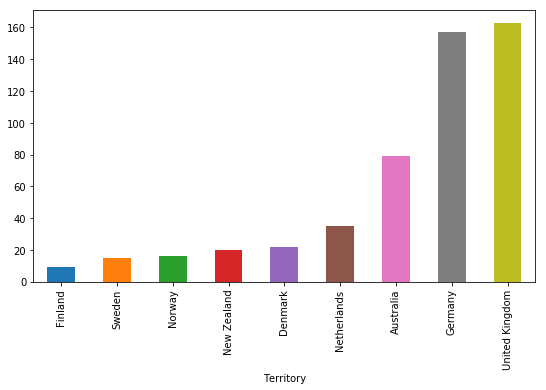

In [71]:
#Let's look at the number of concerts per country in ascending order
concerts_df['Territory'].groupby(concerts_df.Territory).count().sort_values().plot(kind='bar', figsize = (9,5));

In [72]:
#Let's see how many concerts per month
#First, we have to make a new column that is year concatenated with month
concerts_df['Year_Month'] = concerts_df['Year'].astype(str) + concerts_df['Month_Num'].astype(str)

In [73]:
concerts_df['Year_Month'] = concerts_df['Year_Month'].astype(int)

In [74]:
concerts_df.head()

,Artist,Venue,City,Territory,Day_Num,Month_Num,Year,Year_Month
0,Slipknot,Manchester Arena,Manchester,United Kingdom,16,1,2020,20201
1,Slipknot,Utilita Arena,Newcastle upon Tyne,United Kingdom,17,1,2020,20201
2,Dream Theater,Helsinki Ice Hall,Helsinki,Finland,17,1,2020,20201
3,Slipknot,SSE Hydro,Glasgow,United Kingdom,18,1,2020,20201
4,Dream Theater,Club Teatria,Oulu,Finland,18,1,2020,20201


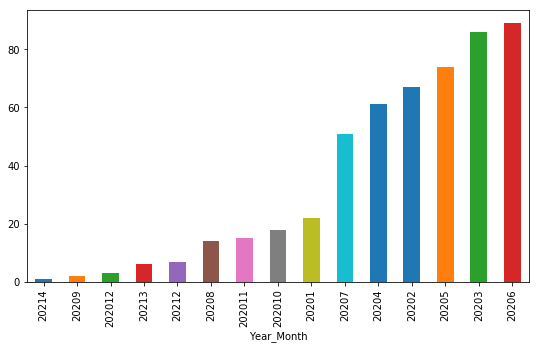

In [75]:
#Unsurprisingly, summer and spring are big concert times, not many concerts have been posted for 2021 yet
concerts_df['Year_Month'].groupby(concerts_df.Year_Month).count().sort_values().plot(kind='bar', figsize = (9,5));

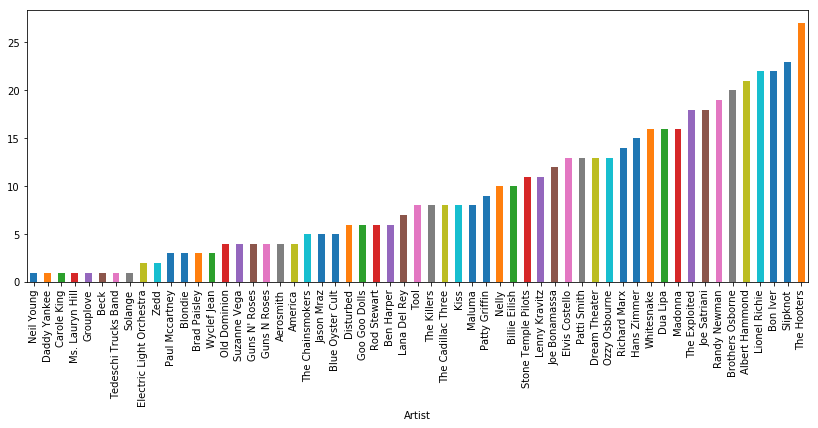

In [76]:
#Let's see who's on tour the most
concerts_df['Artist'].groupby(concerts_df.Artist).count().sort_values().plot(kind='bar', figsize = (14,5));

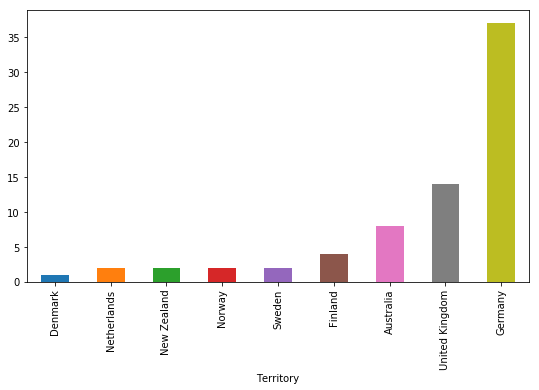

In [77]:
#Let's see where the busiest bands are playing
popular_bands = ['The Hooters', 'Slipknot','Bon Iver']
concerts_df['Artist'][concerts_df['Artist'].isin(popular_bands)].groupby(concerts_df.Territory).count().sort_values().plot(kind='bar', figsize = (9,5));

**Conclusion, you're in luck if you had an itch to see Slipknot or The Hooters in the UK and Germany between March and June!**